<a href="https://colab.research.google.com/github/LucasArais/gemini/blob/main/Detec%C3%A7%C3%A3o_de_objetos_e_bounding_box_com_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de objetos e bounding box com Gemini  

**Conecte-se comigo no [LinkedIn](https://www.linkedin.com/in/lucas-arais/)!**

---

Os modelos [Gemini 2.0 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-2.0-flash) e [Gemini 2.5 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25) podem ser usados para detecção de objetos e bounding box. Este notebook mostra como utilizá-los.

(1408, 768)


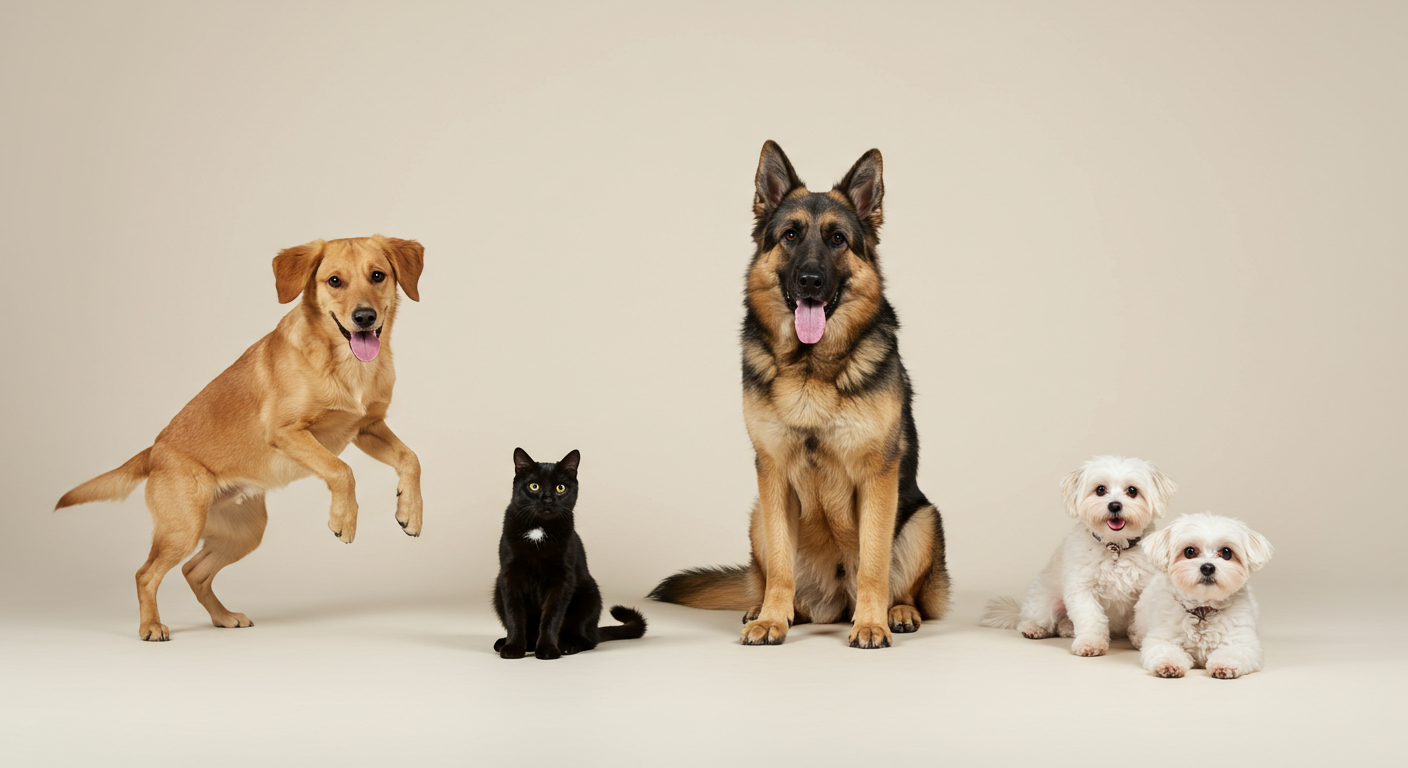

In [11]:
import requests
from io import BytesIO
from PIL import Image   # para ambientes locais, instale Pillow com `pip install Pillow`
url = 'https://raw.githubusercontent.com/LucasArais/gemini/38232978144f4e78c84539b7203adbcb0b3a1aa2/data/animais.png'
image = Image.open(BytesIO(requests.get(url).content))
print(image.size)
image

## Introdução ao Gemini  

Para começar, instale o SDK Python [google-genai](https://github.com/googleapis/python-genai) e obtenha uma [chave de API gratuita](https://aistudio.google.com/app/apikey) no AI Studio.

In [12]:
%pip install -U -q google-genai
# já está instalado no Colab, mas para ambiente local: pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 6.4 MB/s eta 0:00:00


In [13]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [14]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

## Detectar caixas delimitadoras  

Defina o esquema da caixa delimitadora.  

**Importante**: O Gemini retorna as coordenadas da caixa delimitadora neste formato:  
- `[y_min, x_min, y_max, x_max]`  
- e normalizadas para `[0,1000]`

In [15]:
# Definir o esquema da caixa delimitadora.
from pydantic import BaseModel

class BoundingBox(BaseModel):
  box_2d: list[int]
  label: str


Defina o prompt.

In [19]:
prompt = """Detecte as caixas delimitadoras 2D de todos os animais.
O rótulo correspondente deve ser o tipo de animal em portugues-br"""

Execute o modelo. `gemini-2.5-pro-exp-03-25` é muito bom, `gemini-2.0-flash` também funciona bem e é mais rápido.

In [20]:
response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25", # "gemini-2.0-flash"
    contents=[prompt, image],
    config={
        'response_mime_type': 'application/json',
        'response_schema': list[BoundingBox],
    },
)

# Analisar a resposta JSON
bounding_boxes = response.parsed
bounding_boxes

[BoundingBox(box_2d=[667, 799, 884, 904], label='cachorro'),
 BoundingBox(box_2d=[593, 707, 856, 833], label='cachorro'),
 BoundingBox(box_2d=[578, 346, 858, 460], label='gato'),
 BoundingBox(box_2d=[182, 467, 841, 678], label='cachorro'),
 BoundingBox(box_2d=[298, 66, 820, 331], label='cachorro')]

Desenhe as caixas delimitadoras:

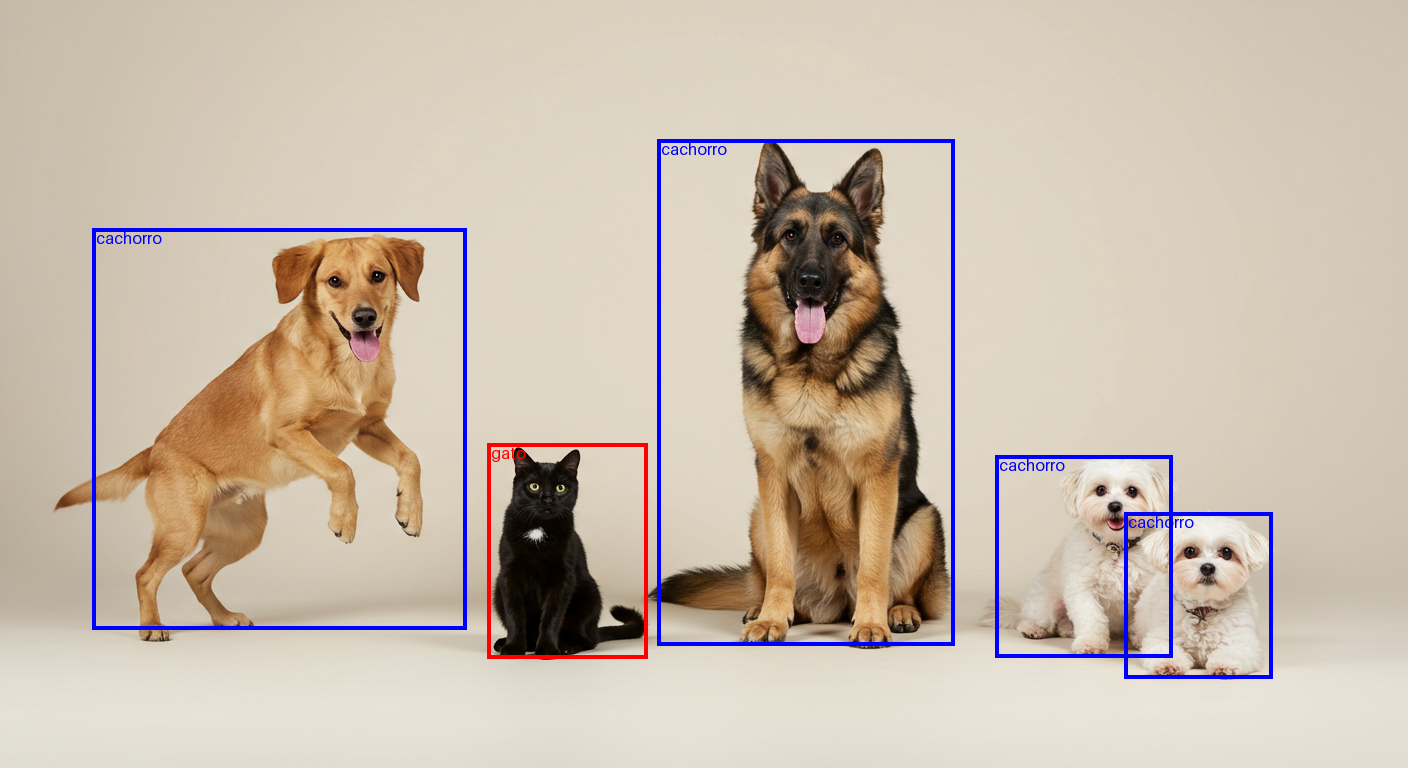

In [21]:
from PIL import ImageDraw, ImageFont

line_width = 4
font = ImageFont.load_default(size=16)

labels = list(set(box.label for box in bounding_boxes))

def draw_bounding_boxes(image, bounding_boxes):
    img = image.copy()
    width, height = img.size

    draw = ImageDraw.Draw(img)

    colors = ['blue','red','green','yellow','orange','pink','purple']

    for box in bounding_boxes:
        y_min, x_min, y_max, x_max = box.box_2d
        label = box.label

        # Converte coordenadas normalizadas para coordenadas absolutas
        y_min = int(y_min/1000 * height)
        x_min = int(x_min/1000 * width)
        y_max = int(y_max/1000 * height)
        x_max = int(x_max/1000 * width)

        color = colors[labels.index(label) % len(colors)]
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)

        draw.text((x_min+line_width, y_min), label, fill=color, font=font)

    display(img)

draw_bounding_boxes(image, bounding_boxes)

 🔗 **Quer trocar ideias ou acompanhar mais conteúdos sobre tecnologia?** Me conecte no [LinkedIn](https://www.linkedin.com/in/lucas-arais/)!